# MSP Italy - Exploratory data analysis

* automatic analysis of the Italian MSP plan

In [10]:
# input core packages and util functions
%matplotlib inline

import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
from upsetplot import from_memberships, plot as upplot, UpSet

from utils import use_codes_list as _use_codes_list, dfuses as _dfuses
import types
from pyproj import Geod
from pandas_profiling import ProfileReport
import contextily as cx
import rioxarray



# add method to GeoDataFrame class
def geodetic_area_perimeter(self):
    crs = self.crs
    _geod = self.crs.get_geod()
    geodetic_crs = self.crs.geodetic_crs
    _geometry = self.geometry.to_crs(geodetic_crs)
    def _a_p(g):
        a_p = _geod.geometry_area_perimeter(g)
        return abs(a_p[0]), abs(a_p[1])
    return pd.DataFrame(_geometry.apply(lambda g: _a_p(g)).to_list(),
                        index=self.index, columns=['geodetic_area', 'geodetic_perimeter'])
setattr(gpd.GeoDataFrame, 'geodetic_area_perimeter', geodetic_area_perimeter)


# annotated stackedbarplot
def add_annotation(ax, suffix=""):
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        txt = ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} {}'.format(height, suffix), 
                horizontalalignment='center', 
                verticalalignment='center')
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        # txt.set_bbox(dict(facecolor='white', 
        #                   # alpha=0.5, 
        #                   edgecolor='white'))
    return ax

## Loading and cleaning the MSP-Italy plans

In [11]:
# Loading geospatial datasets load from the MSP-Italy planning geopackage
source = 'data/planning.gpkg'

AREA_LABELS = {'A': 'Adriatic',
               'IMC': 'Ionian/Central Mditerranean',
              'MO': 'Tyrrenian/Western Mediterranean'}

dfuses = gpd.read_file(source, layer="pu_uses").set_index("code")
code_label_eng = {
    '0100': 'f',
    '0200': 'tm',
    '0300': 'n',
    '0400': 'e',
    '0500': 'sa',
    '0600': 'd',
    '0700': 't',
    '0900': 'tel',
    '1000': 'ppc',
    '1100': 'ds',
    '1200': 'cd',
    '1300': 's',
    '1400': 'r',
    '1500': 'a'
}
dfuses['label_eng'] = dfuses.index.to_series().replace(code_label_eng)

code_use_eng_short = {
    '0100': 'Fishery',
    '0200': 'Maritime transport',
    '0300': 'Environmental protection',
    '0400': 'Energy',
    '0500': 'Sand extrac. & dumping',
    '0600': 'Military defence',
    '0700': 'Tourism',
    '0900': 'Telecommunications',
    '1000': 'Landscape and cult. herit.',
    '1100': 'Dumping sites',
    '1200': 'Coastal defense',
    '1300': 'Maritime safety',
    '1400': 'Research',
    '1500': 'Aquaculture'    
}
dfuses['use_eng_short'] = dfuses.index.to_series().replace(code_use_eng_short)


In [12]:
# cleaning and setup multi-uses representations
msp_areas = gpd.read_file(source, layer="areas")
msp_subareas = gpd.read_file(source, layer="subareas")
msp_subareas.rename(columns={'name': 'location'}, inplace=True)
planning_units = gpd.read_file(source, layer="planning_units")
planning_units['subarea'] = planning_units.Code.str.replace('_\d+', '')
planning_units['msp'] = planning_units.Code.str.replace('/\d+_\d+', '')
# non serve più il merge perche' ora location è presente anche nelle planning units
# planning_units = planning_units.merge(msp_subareas[['subarea','location']], on="subarea")
planning_units['main_uses_sorted_list'] = planning_units.main_uses.str.split(',').apply(lambda x: tuple(sorted([i.strip().zfill(4) for i in x])) if isinstance(x, list) else ())
planning_units['other_uses_sorted_list'] = planning_units.other_uses.str.split(',').apply(lambda x: tuple(sorted([i.strip().zfill(4) for i in x])) if isinstance(x, list) else ())
planning_units['main_uses_sorted_list_labels'] = planning_units.main_uses_sorted_list.apply(lambda x: tuple([dfuses.use_eng_short.get(u, 'undefined') for u in x]))
planning_units['main_uses_sorted_list_codes'] = planning_units.main_uses_sorted_list.apply(lambda x: tuple([dfuses.label_eng.get(u, 'u') for u in x]))

In [16]:
# assign generic typology
_filter = planning_units.main_uses_sorted_list==('0000',)
glabel = 'PUs of Generic typology'
planning_units.loc[_filter, 'main_uses_sorted_list_labels'] = planning_units[_filter].main_uses_sorted_list_labels.apply(lambda x: (glabel,))

## Data validation

### Search for undefined uses

In [17]:
planning_units[planning_units.main_uses_sorted_list_labels.apply(lambda x: 'undefined' in x)][['Code', 'main_uses', 'main_uses_sorted_list_labels']]

,Code,main_uses,main_uses_sorted_list_labels


### Search for invalid geometries 

In [18]:
planning_units[~planning_units.geometry.is_valid]

,id,Code,Type,pu_type,lbl_x,lbl_y,pu_types,label,main_uses,other_uses,...,location,area_km,subarea,note,geometry,msp,main_uses_sorted_list,other_uses_sorted_list,main_uses_sorted_list_labels,main_uses_sorted_list_codes


## Calculate geodetic perimeter and area

In [19]:
# remove invalid geometries (if any)
planning_units = planning_units[planning_units.geometry.is_valid].copy()

In [20]:
# add alternative surface computation
_g_a_p = planning_units.geodetic_area_perimeter()
planning_units['geoarea'] = _g_a_p['geodetic_area'] / 1E6
planning_units['geoperimeter'] = _g_a_p['geodetic_perimeter'] / 1E3
totarea = planning_units.geoarea.sum()
planning_units['geoarea_perc'] = planning_units.geoarea / totarea * 100
# english trnslation
planning_units['location'] = planning_units.location.replace({'acque terr': 'coastal'})

# Planning units profile Report

In [29]:
pcolumns = ['Code', 'Type', 'msp', 'subarea', 'pu_type', 'area_km', 'geoarea', 'geoperimeter']
plannin_unit_profile = ProfileReport(planning_units[pcolumns], title="Planning Units Report")
plannin_unit_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Marine areas

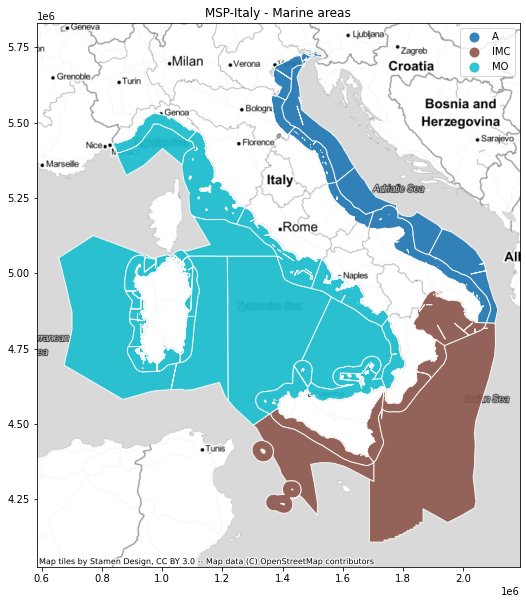

In [30]:
ax = planning_units.dissolve(by='subarea').to_crs(epsg=3857).plot(column="msp", legend=True, 
                                           edgecolor='white',
                                           figsize=[10, 10], alpha=0.9)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_title("MSP-Italy - Marine areas")
plt.savefig("exploratory_outputs/msp_italy_marine_areas.png")
plt.show()

### MSP Area surfaces

In [36]:
planning_units.groupby('msp').sum()[['area_km', 'geoarea', 'geoarea_perc']]

,area_km,geoarea,geoarea_perc
msp,,,
A,62275.68,62281.446403,11.353267
IMC,176246.75,176260.252505,32.130432
MO,309444.98,310035.593960,56.516301


# Sub-areas

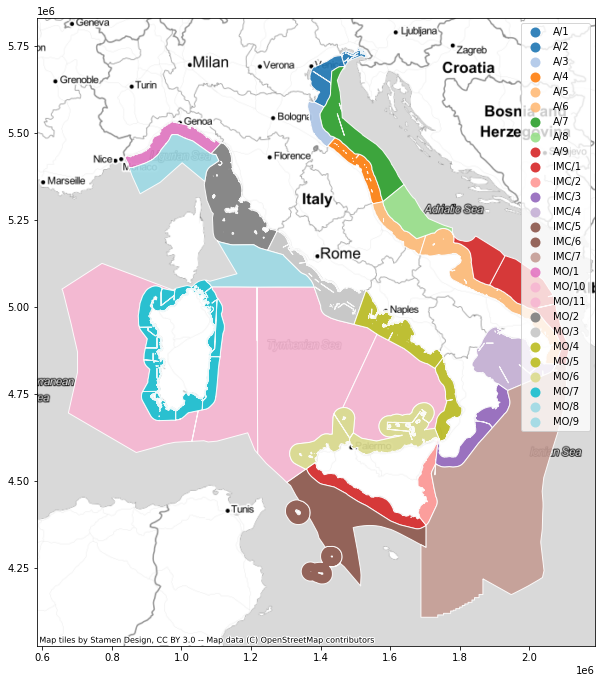

In [31]:
subareas = planning_units.dissolve(by='subarea').reset_index()[['subarea', 'geometry']]
ax = subareas.to_crs(epsg=3857).plot(column="subarea", legend=True, 
                                           edgecolor='white',
                                           figsize=[10, 20], alpha=0.9, cmap="tab20")
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
plt.show()

In [38]:
planning_units.groupby(['msp', 'subarea']).sum()[['area_km', 'geoarea', 'geoarea_perc']]

area_km        geoarea  geoarea_perc
msp subarea                                        
A   A/1         826.10     826.097070      0.150589
    A/2        3465.10    3465.093644      0.631651
    A/3        2237.65    2237.655302      0.407902
    A/4        3837.07    3837.078525      0.699460
    A/5        3444.24    3444.246743      0.627851
    A/6       12766.76   12772.494012      2.328294
    A/7       11248.19   11248.196458      2.050431
    A/8        6851.67    6851.678030      1.248990
    A/9       17598.90   17598.906619      3.208100
IMC IMC/1      7791.96    7791.966123      1.420395
    IMC/2      4596.66    4596.666398      0.837925
    IMC/3      7492.23    7492.229586      1.365756
    IMC/4     13921.09   13923.112043      2.538040
    IMC/5      7242.93    7254.392103      1.322401
    IMC/6     23813.49   23813.499496      4.340956
    IMC/7    111388.39  111388.386755     20.304958
MO  MO/1       5454.47    5454.475348      0.994295
    MO/10    101770.54  101770.541891     18.551723
    MO/11     96589.38   96589.383869     17.607252
    MO/2      16215.23   16723.271425      3.048480
    MO/3      10617.38   10625.591347      1.936936
    MO/4       9118.54    9118.520979      1.662213
    MO/5       4817.39    4817.391467      0.878161
    MO/6      19169.29   19242.179338      3.507651
    MO/7      22633.38   22634.855591      4.126101
    MO/8       9942.00    9941.998033      1.812324
    MO/9      13117.38   13117.384672      2.391164

## PUs and Location (coastal and offshore) statistics

In [14]:
pu_agg = planning_units.groupby(['msp','location'])\
.agg(
    PUs=pd.NamedAgg(column="Code", aggfunc="count"),
    kmq=pd.NamedAgg(column="area_km", aggfunc="sum"),
    geoarea=pd.NamedAgg(column="geoarea", aggfunc="sum"),
    geoarea_perc=pd.NamedAgg(column="geoarea_perc", aggfunc="sum"),
    maxarea=pd.NamedAgg(column="geoarea", aggfunc="max"),
    minarea=pd.NamedAgg(column="geoarea", aggfunc="min"),
)
# pu_agg.to_html()

In [15]:
ax = pu_agg.reset_index().pivot(index="msp", columns="location", values='geoarea').plot.bar(stacked=True)
add_annotation(ax)
ax.set_xlabel('MSP areas')
ax.set_ylabel('km2')
ax.set_title("PU surfaces")
plt.show()

In [16]:
ax = pu_agg.reset_index().pivot(index="msp", columns="location", values='geoarea_perc').plot.bar(stacked=True)
add_annotation(ax, suffix="%")
ax.set_xlabel('MSP areas')
ax.set_ylabel('%')
ax.set_title("PU areas")
plt.show()

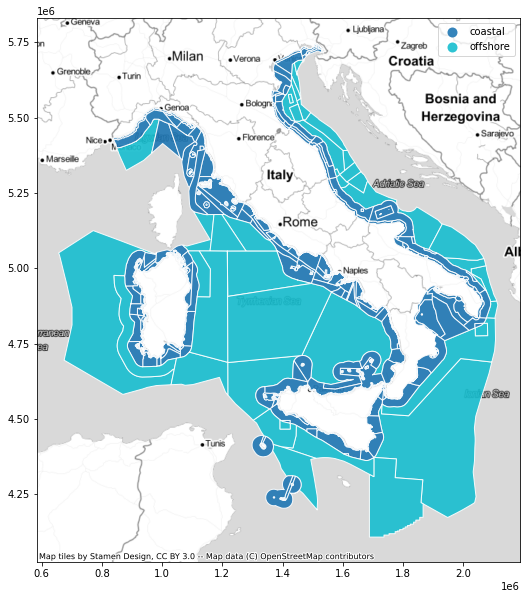

In [23]:
ax = planning_units.to_crs(epsg=3857).plot(column="location", 
                                           edgecolor='white',
                                           legend=True, figsize=[10, 10], alpha=0.9)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
plt.show()

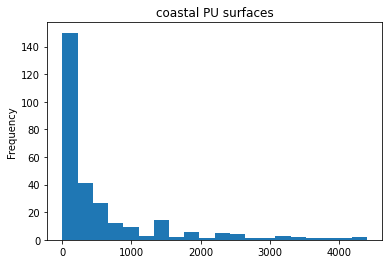

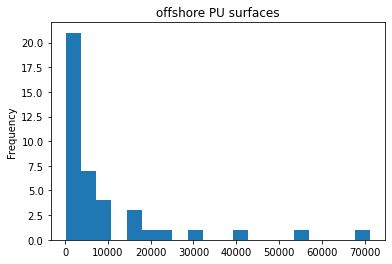

In [24]:
# ax = planning_units[[geoarea.plot.hist()
# ax.set_title('PU surface distribution')
# plt.show()
for l in ['coastal', 'offshore']:
    _df = planning_units[planning_units.location==l]
    ax = _df.geoarea.plot.hist(bins=20)
    ax.set_title('{} PU surfaces'.format(l))
    plt.show()

## PU types statistics

In [25]:
pu_agg = planning_units.groupby(['msp','pu_type'])\
.agg(
    PUs=pd.NamedAgg(column="Code", aggfunc="count"),
    kmq=pd.NamedAgg(column="area_km", aggfunc="sum"),
    geoarea=pd.NamedAgg(column="geoarea", aggfunc="sum"),
    geoarea_perc=pd.NamedAgg(column="geoarea_perc", aggfunc="sum"),
    maxarea=pd.NamedAgg(column="geoarea", aggfunc="max"),
    minarea=pd.NamedAgg(column="geoarea", aggfunc="min"),
)

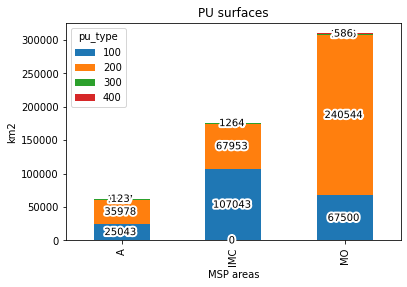

In [26]:
ax = pu_agg.reset_index().pivot(index="msp", columns="pu_type", values='geoarea').plot.bar(stacked=True)
add_annotation(ax)
ax.set_xlabel('MSP areas')
ax.set_ylabel('km2')
ax.set_title("PU surfaces")
plt.show()

## Main uses classification and analysis

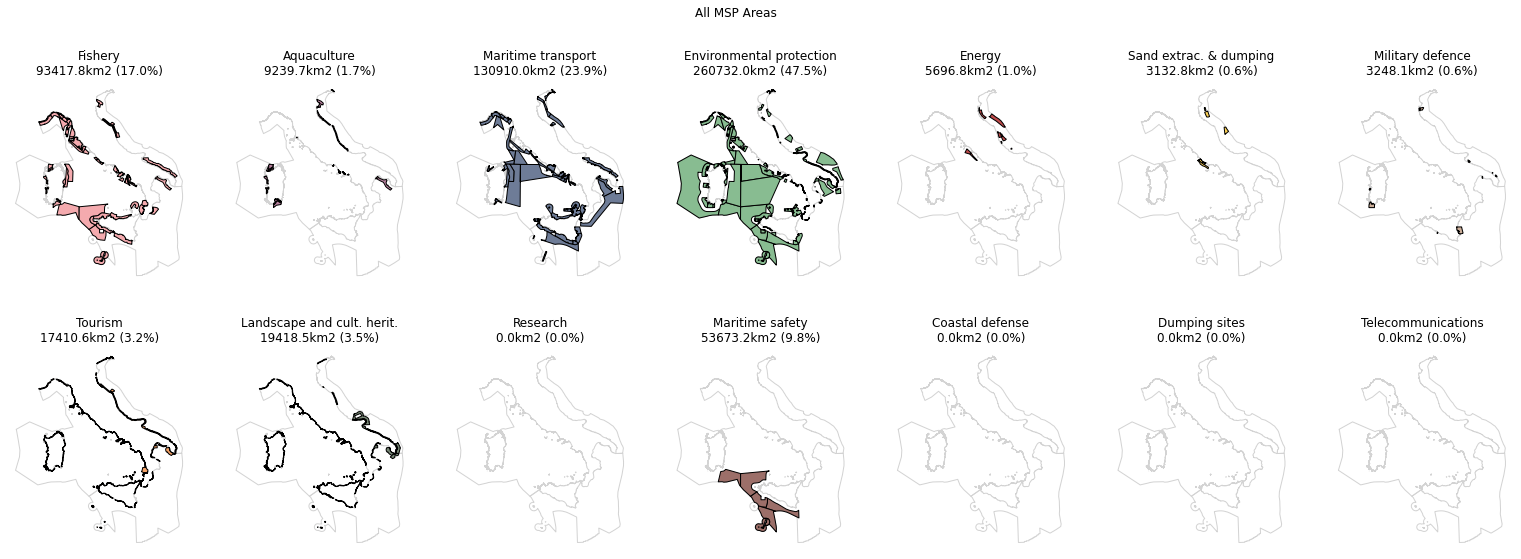

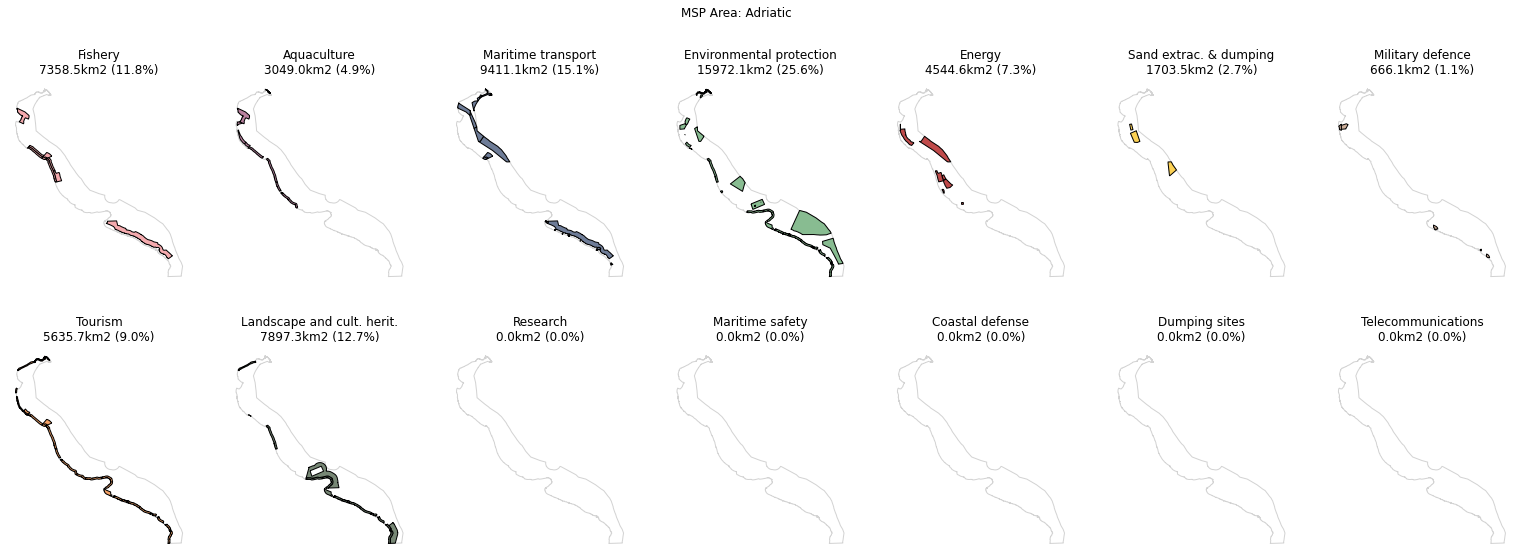

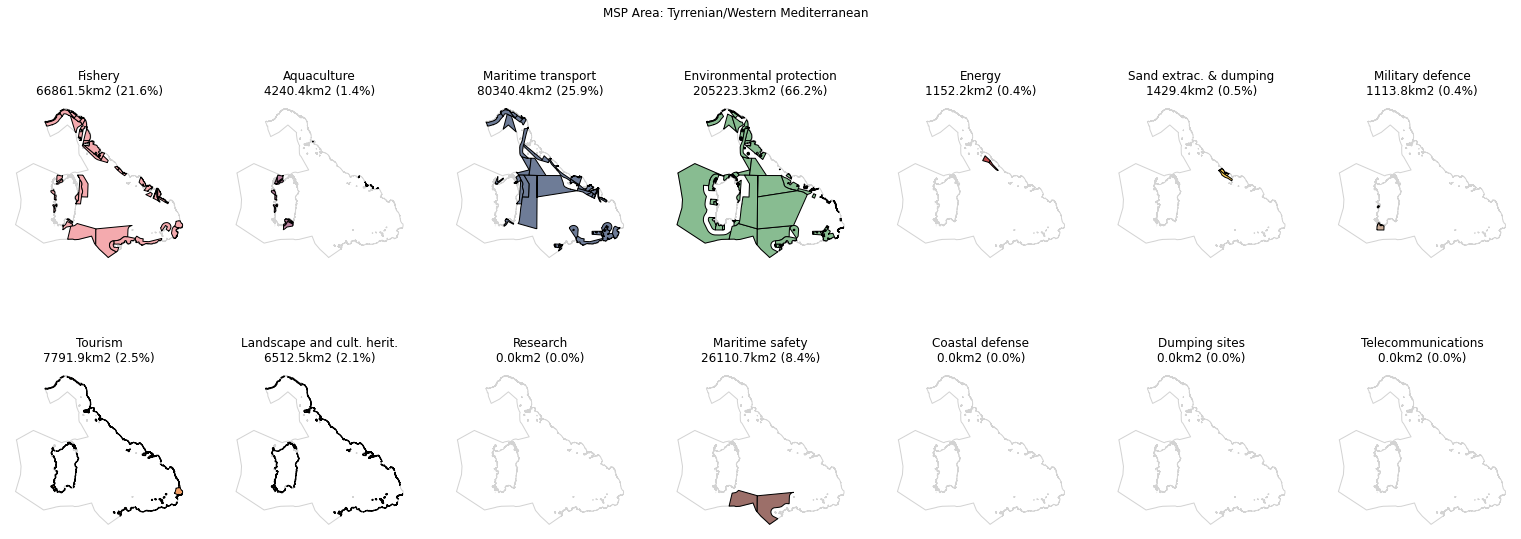

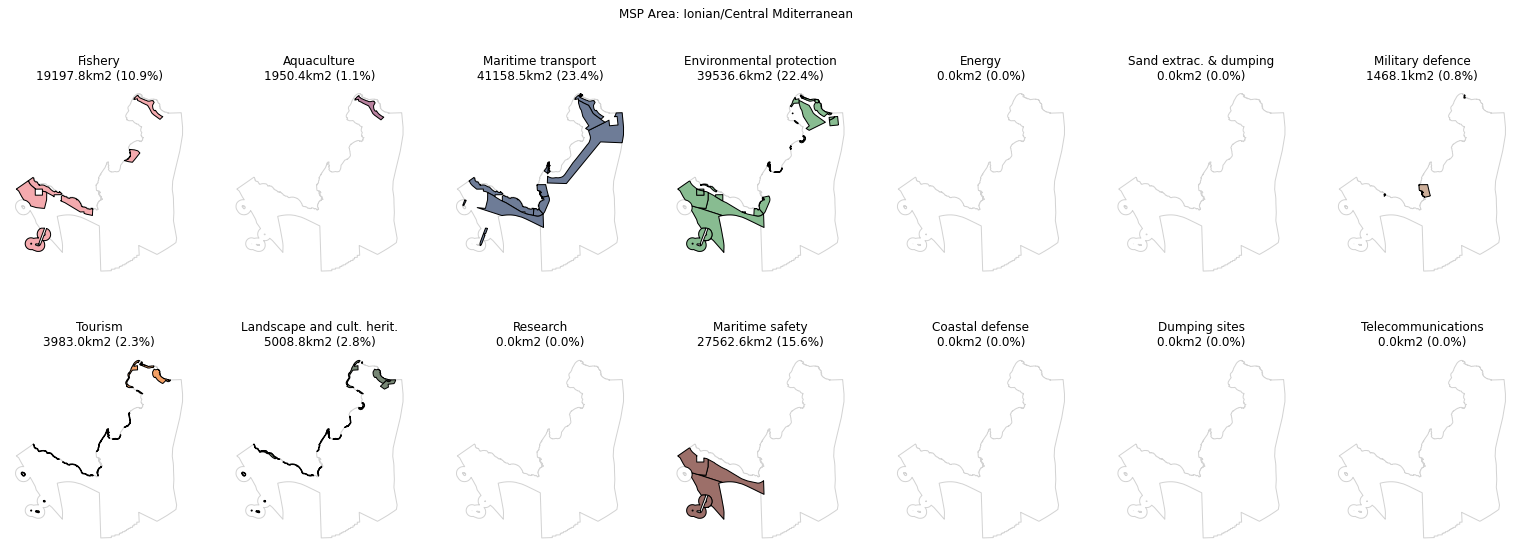

In [27]:
msps = [None, 'A', 'MO', 'IMC']
for m in msps:
    fig, axs = plt.subplots(2, 7, figsize=[27, 9])#, subplot_kw=dict(projection="polar"))
    i = 0
    if m is not None:
        _msp_areas = msp_areas[msp_areas['area']==m]
        df = planning_units[planning_units.msp==m]
        title = "MSP Area: {}".format(AREA_LABELS.get(m))
    else:
        _msp_areas = msp_areas.copy()
        df = planning_units.copy()
        title = "All MSP Areas"
    _totsurface = df.geoarea.sum()
    for _code, u in dfuses.iterrows():
        code = "{}".format(_code).zfill(4)
        label = u.use_eng_short
        color = u.color
        if color == '#':
            continue
        ax = axs.flatten()[i]
        _df = df[df.main_uses.str.contains(code).fillna(False)]
        _msp_areas.plot(ax=ax, edgecolor='lightgrey', color='None')
        if _df.shape[0] > 0:
            _df.plot(ax=ax, color=color, edgecolor='black')
        plot_label = "{}\n{}km2 ({}%)".format(label.capitalize(), _df.geoarea.sum().round(1), (_df.geoarea.sum()/_totsurface * 100).round(1))
        ax.set_title(plot_label)
        ax.set_axis_off()
        # cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

        # print(code, label, _df.shape)
        i += 1
    plt.suptitle(title)
    plt.show()




In [28]:
data = []
for id, r in planning_units.iterrows():
    if r.main_uses is None:
        continue
    main_uses = r.main_uses.split(',')
    multi = True if len(main_uses)>1 else False
    if r.geometry is None:
        continue
    geoarea_perc = r.geoarea_perc
    location = r.location
    msp = r.msp
    if multi:
        multiarea = geoarea_perc
    else:
        multiarea = 0
    for u in main_uses:
        # print(id, u, int(u))
        # u_label = dfuses.at[int(u), 'label']
        u_label = dfuses.use_eng_short.get(u, {'0000': glabel}.get(u, 'undefined'))
        u_code = dfuses.label_eng.get(u, 'u')
        data.append([u_label, u_code, geoarea_perc, multiarea, location, msp])
df_main_uses = pd.DataFrame(data, columns=['use', 'label_eng', 'geoarea_perc', 'multiarea', 'location', 'msp'])
df_main_uses['singlearea'] = df_main_uses.geoarea_perc - df_main_uses.multiarea

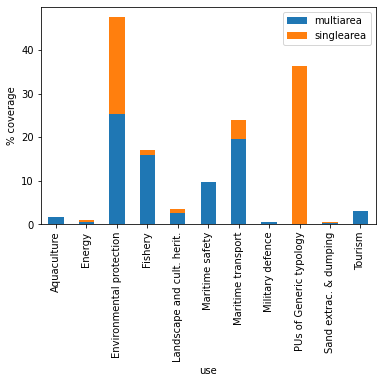

In [29]:
_df = df_main_uses.groupby('use').sum()
ax = _df[['multiarea', 'singlearea']].plot.bar(stacked=True)
ax.set_ylabel('% coverage')
plt.show()

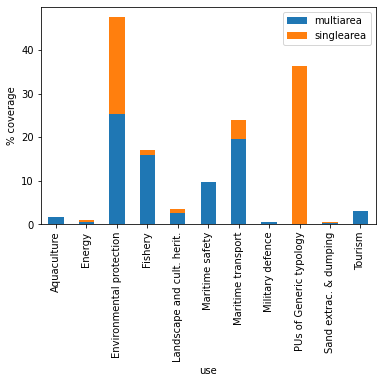

In [30]:
_df = df_main_uses.groupby('use').sum()
ax = _df[['multiarea', 'singlearea']].plot.bar(stacked=True)
ax.set_ylabel('% coverage')
plt.show()

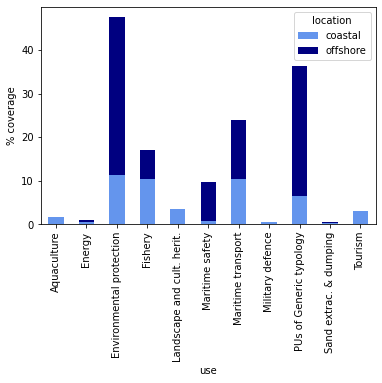

In [31]:
_df = df_main_uses.groupby(['use', 'location']).sum()
_df = _df.reset_index().pivot(index='use', values='geoarea_perc', columns='location')
ax = _df.plot.bar(stacked=True,
             color={"offshore": "navy", "coastal": "cornflowerblue"}
            )
ax.set_ylabel('% coverage')
plt.show()

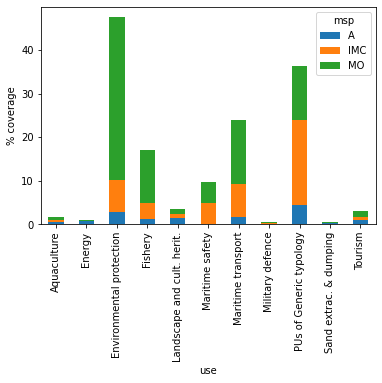

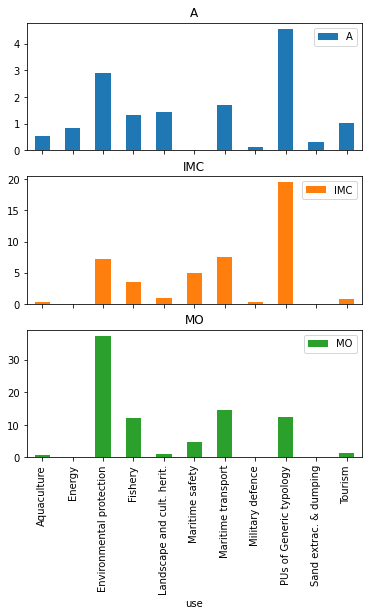

In [32]:
_df = df_main_uses.groupby(['use', 'msp']).sum()
_df = _df.reset_index().pivot(index='use', values='geoarea_perc', columns='msp')
ax = _df.plot.bar(stacked=True,
             # color={"offshore": "navy", "costiera": "cornflowerblue"}
            )
ax.set_ylabel('% coverage')
plt.show()
_df.plot.bar(subplots=True, figsize=[6, 8])
# ax.set_ylabel('% coverage')
plt.show()

# Multi-use analysis

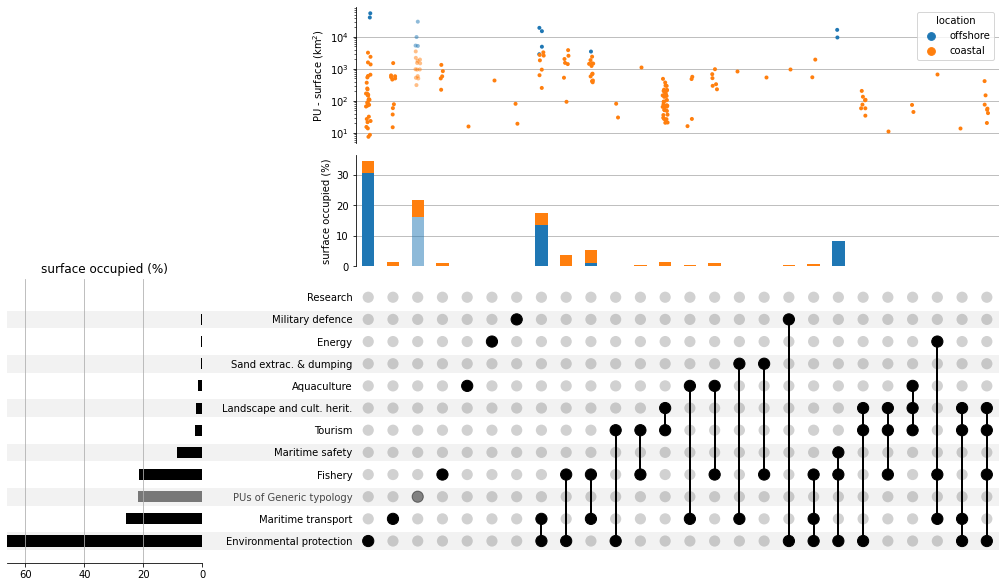

In [33]:

# for area in ['A', 'IMC', 'MO']:
for area in ['MO']:  
    _filter = planning_units.msp == area
    _df = planning_units[_filter].copy()
    # recalculate perc
    _df['geoarea_perc'] = _df['geoarea'] / _df.geoarea.sum() * 100
    # _filter = _df.main_uses.notnull()
    # _df = _df[_filter].copy()
    _df.main_uses_sorted_list_labels = _df.main_uses_sorted_list_labels.apply(lambda x: x if len(x)>0 else (glabel,))
    # _df = _df.groupby(['main_uses_sorted_list_labels', 'location'])[['geoarea', 'geoarea_perc']].sum().reset_index('location')
    # upset_data = from_memberships(_df.main_uses_sorted_list_codes,
    #                               data=_df[['geoarea', 'geoarea_perc', 'location']])
    upset_data = from_memberships(_df.main_uses_sorted_list_labels,
                                  data=_df[['geoarea', 'geoarea_perc', 'location']])
    
    # add research & innovation empty
    # upset_data['r'] = False
    # upset_data = upset_data.set_index('r', append=True)
    upset_data['Research'] = False
    upset_data = upset_data.set_index('Research', append=True)
    
    # upplot(upset_data)
    upset = UpSet(upset_data,
                  sum_over="geoarea_perc",
                  intersection_plot_elements=0,
                  totals_plot_elements=8,
                 #  show_counts='%d%%',
                  # show_percentages=True,
                 )  # disable the default bar chart
    if glabel in upset_data.index.names:
        upset.style_subsets(present=glabel, facecolor="#00000077")
    bars = upset.add_stacked_bars(by="location", 
                           #colors=cm.Pastel1,
                           # title="% of combination of uses \nover the MSP area surface", 
                           # title="combination of uses\nsurface (%)", 
                           # title = "share of the total MA\nsurface occupied (%)",
                           title = "surface occupied (%)",
                           sum_over="geoarea_perc",
                           elements=5)
    upset.add_catplot(value='geoarea',
                      kind='strip', 
                      elements=6, hue='location', size=4, hue_order=['offshore', 'coastal'])
    plots = upset.plot()
    # plots['extra0'].set(yscale="log")
    # plots['extra0'].set(ylabel="area (km2)")
    # plots['totals'].set_title("% of use\nover the MSP area surface")
    # plots['totals'].set_title("use - surface (%)")
    plots['totals'].set_title("surface occupied (%)")
    plots['extra0'].get_legend().remove()
    plots['extra1'].set(ylabel="PU - surface (km$^2$)")
    plots['extra1'].set(yscale="log")
    # add alpha to generic PU
    plots['totals'].get_children()[2].set_alpha(0.5)
    plots['extra0'].get_children()[2].set_alpha(0.5)
    plots['extra1'].get_children()[2].set_alpha(0.5)
    plots['matrix'].get_yticklabels()[2].set_alpha(0.7)
    # plots['matrix'].figure.suptitle(area)
    # plots['matrix'].figure.subplots_adjust(top=0.93) # adjust the Figure in rp
    # plots['matrix'].figure.suptitle("Coexistence analysis - Vocational uses: {} MSP area".format(AREA_LABELS.get(area)))
    plt.savefig("exploratory_outputs/multiuse_{}.svg".format(area))
    plt.savefig("exploratory_outputs/multiuse_{}.png".format(area), dpi=300)
    _df[['Code', 'Type', 'main_uses_sorted_list_labels', 'geoarea', 'geoarea_perc']].to_html("exploratory_outputs/multiuse_{}.html".format(area))
    plt.show()

In [34]:
_filter = planning_units.msp == 'MO'
dft = planning_units[_filter].copy()
dft['putype'] = dft.Type.str[:1]
dft['geoarea_perc'] = dft['geoarea'] / dft.geoarea.sum() * 100

In [35]:
dft.groupby('location').size()

location
coastal     165
offshore     13
dtype: int64

In [36]:
dft.groupby(['subarea']).size()

subarea
MO/1     15
MO/10     4
MO/11     5
MO/2     21
MO/3     22
MO/4     31
MO/5     10
MO/6     24
MO/7     40
MO/8      3
MO/9      3
dtype: int64

In [37]:
dft.groupby(['putype']).size()

putype
G     17
L     18
P    137
R      6
dtype: int64

In [38]:
dft[dft.main_uses_sorted_list.apply(len)>=2].geoarea_perc.sum()

40.765238337817216

In [39]:
dft.groupby(dft.main_uses_sorted_list).size()

main_uses_sorted_list
(0000,)                     17
(0100,)                      5
(0100, 0200)                13
(0100, 0200, 0300)           2
(0100, 0200, 0400)           1
(0100, 0300)                 7
(0100, 0300, 0700, 1000)     7
(0100, 0300, 1300)           2
(0100, 0500)                 1
(0100, 0700)                 1
(0100, 0700, 1000)           1
(0100, 1500)                 6
(0200,)                     10
(0200, 0300)                11
(0200, 0300, 0700, 1000)     1
(0200, 0500)                 1
(0200, 1500)                 4
(0300,)                     33
(0300, 0600)                 1
(0300, 0700)                 2
(0300, 0700, 1000)           8
(0400,)                      1
(0600,)                      2
(0700, 1000)                38
(0700, 1000, 1500)           2
(1500,)                      1
dtype: int64

In [40]:
dft.groupby(dft.main_uses_sorted_list).geoarea_perc.sum()

main_uses_sorted_list
(0000,)                     21.771592
(0100,)                      1.122604
(0100, 0200)                 5.329937
(0100, 0200, 0300)           0.802577
(0100, 0200, 0400)           0.226953
(0100, 0300)                 3.868596
(0100, 0300, 0700, 1000)     0.260488
(0100, 0300, 1300)           8.421823
(0100, 0500)                 0.178600
(0100, 0700)                 0.376807
(0100, 0700, 1000)           0.003706
(0100, 1500)                 0.973665
(0200,)                      1.426322
(0200, 0300)                17.489924
(0200, 0300, 0700, 1000)     0.004706
(0200, 0500)                 0.282431
(0200, 1500)                 0.350425
(0300,)                     34.732181
(0300, 0600)                 0.327082
(0300, 0700)                 0.035860
(0300, 0700, 1000)           0.250220
(0400,)                      0.144682
(0600,)                      0.032181
(0700, 1000)                 1.543020
(0700, 1000, 1500)           0.038418
(1500,)                     

In [41]:
dft[dft.main_uses_sorted_list.apply(lambda x: '0700' in x and '1000' in x)].groupby(dft.main_uses_sorted_list).geoarea_perc.sum().sum()

2.1005589279265657

In [42]:
dft[dft.main_uses_sorted_list.apply(lambda x: '0700' in x and '1000' in x)].groupby(dft.main_uses_sorted_list).geoarea_perc.size()

main_uses_sorted_list
(0100, 0300, 0700, 1000)     7
(0100, 0700, 1000)           1
(0200, 0300, 0700, 1000)     1
(0300, 0700, 1000)           8
(0700, 1000)                38
(0700, 1000, 1500)           2
Name: geoarea_perc, dtype: int64

In [43]:
_df = dft[dft.location=='offshore']
_df[_df.main_uses_sorted_list.apply(lambda x: '0200' in x and '0300' in x)].groupby(_df.main_uses_sorted_list).geoarea_perc.sum()

main_uses_sorted_list
(0200, 0300)    13.537657
Name: geoarea_perc, dtype: float64

In [44]:
_df[_df.main_uses_sorted_list.apply(lambda x: '0200' in x and '0300' in x)].groupby(_df.main_uses_sorted_list).size()

main_uses_sorted_list
(0200, 0300)    4
dtype: int64

In [45]:
dft[dft.main_uses_sorted_list==('0300',)].geoarea_perc.sum()

34.73218113234649

In [46]:
dft.geoarea_perc.sum()

100.0

In [47]:
dft

,id,Code,Type,pu_type,lbl_x,lbl_y,pu_types,label,main_uses,other_uses,...,note,geometry,msp,main_uses_sorted_list,other_uses_sorted_list,main_uses_sorted_list_labels,main_uses_sorted_list_codes,geoarea,geoarea_perc,putype
34,NaN,MO/5_04,"P(n,t)",200,NaN,NaN,Prioritary,"MO/5_04 | P(n,t)","0300,0700","0100,0200,0400,0500,0600,0900,1000,1100,1200,1...",...,Usi citati nel piano: Trasporto mar. portualit...,"MULTIPOLYGON (((7345653.071 4328659.007, 73447...",MO,"(0300, 0700)","(0100, 0200, 0400, 0500, 0600, 0900, 1000, 110...","(Environmental protection, Tourism)","(n, t)",81.119723,0.026165,P
35,NaN,MO/5_05,"P(p,t)",200,NaN,NaN,Prioritary,"MO/5_05 | P(p,t)","0100,0700","0200,0300,0400,0500,0600,0900,1000,1100,1200,1...",...,"Usi citati nel piano: Acquacoltura,Energia","MULTIPOLYGON (((7321594.842 4299715.977, 73242...",MO,"(0100, 0700)","(0200, 0300, 0400, 0500, 0600, 0900, 1000, 110...","(Fishery, Tourism)","(f, t)",1168.236234,0.376807,P
36,NaN,MO/5_06,"P(n,ppc,t)",200,NaN,NaN,Prioritary,"MO/5_06 | P(n,ppc,t)","0300,0700,1000","0100,0200,0400,0500,0600,0900,1100,1200,1300,1...",...,"Usi citati nel piano: Pesca,Trasporto mar. por...","MULTIPOLYGON (((7341765.437 4269565.380, 73398...",MO,"(0300, 0700, 1000)","(0100, 0200, 0400, 0500, 0600, 0900, 1100, 120...","(Environmental protection, Tourism, Landscape ...","(n, t, ppc)",103.926533,0.033521,P
37,NaN,MO/5_08,"P(n,ppc,p,t)",200,NaN,NaN,Prioritary,"MO/5_08 | P(n,ppc,p,t)","0100,0300,0700,1000","0200,0400,0500,0600,0900,1100,1200,1300,1400,1500",...,"Usi citati nel piano: Energia,Telecom.","MULTIPOLYGON (((7324637.350 4235925.355, 73238...",MO,"(0100, 0300, 0700, 1000)","(0200, 0400, 0500, 0600, 0900, 1100, 1200, 130...","(Fishery, Environmental protection, Tourism, L...","(f, n, t, ppc)",41.213491,0.013293,P
38,NaN,MO/5_09,"P(n,ppc,tm,t)",200,NaN,NaN,Prioritary,"MO/5_09 | P(n,ppc,tm,t)","0200,0300,0700,1000","0100,0400,0500,0600,0900,1100,1200,1300,1400,1500",...,"Usi citati nel piano: Pesca,Energia,Sicurezza ...","MULTIPOLYGON (((7323851.550 4237794.948, 73238...",MO,"(0200, 0300, 0700, 1000)","(0100, 0400, 0500, 0600, 0900, 1100, 1200, 130...","(Maritime transport, Environmental protection,...","(tm, n, t, ppc)",14.591538,0.004706,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,323.0,MO/4_08,"P(t,n,ppc)",200,NaN,NaN,None,"MO/4_08 | P(t,n,ppc)","0300,0700,1000","0100,0200,0400,0500,0600,0900,1100,1200,1300,1...",...,"Usi citati nel piano: Ricerca sc. e innovaz.,D...","MULTIPOLYGON (((7204470.525 4502525.472, 72044...",MO,"(0300, 0700, 1000)","(0100, 0200, 0400, 0500, 0600, 0900, 1100, 120...","(Environmental protection, Tourism, Landscape ...","(n, t, ppc)",203.809866,0.065738,P
311,324.0,MO/4_03,"P(n,ppc,t)",200,NaN,NaN,None,"MO/4_03 | P(n,ppc,t)","0300,0700,1000","0100,0200,0400,0500,0600,0900,1100,1200,1300,1...",...,"Usi citati nel piano: Difesa costiera,Energia,...","MULTIPOLYGON (((7170045.030 4512156.563, 71702...",MO,"(0300, 0700, 1000)","(0100, 0200, 0400, 0500, 0600, 0900, 1100, 120...","(Environmental protection, Tourism, Landscape ...","(n, t, ppc)",134.031751,0.043231,P
312,325.0,MO/4_23,"P(tm,n)",200,NaN,NaN,None,"MO/4_23 | P(tm,n)","0200,0300","0100,0400,0500,0600,0700,0900,1000,1100,1200,1...",...,"Usi citati nel piano: Energia,Ricerca sc. e in...","MULTIPOLYGON (((7206393.596 4471342.064, 72065...",MO,"(0200, 0300)","(0100, 0400, 0500, 0600, 0700, 0900, 1000, 110...","(Maritime transport, Environmental protection)","(tm, n)",252.656746,0.081493,P
313,326.0,MO/4_21,"P(p,tm)",200,NaN,NaN,None,"MO/4_21 | P(p,tm)","0100,0200","0300,0400,0500,0600,0700,0900,1000,1100,1200,1...",...,"Usi citati nel piano: Turismo ,Energia,Ricerca...","MULTIPOLYGON (((7196198.109 4479345.749, 71963...",MO,"(0100, 0200)","(0300, 0400, 0500, 0600, 0700, 0900, 1000, 110...","(Fishery, Maritime transport)","(f, tm)",411.188449,0.132626,P


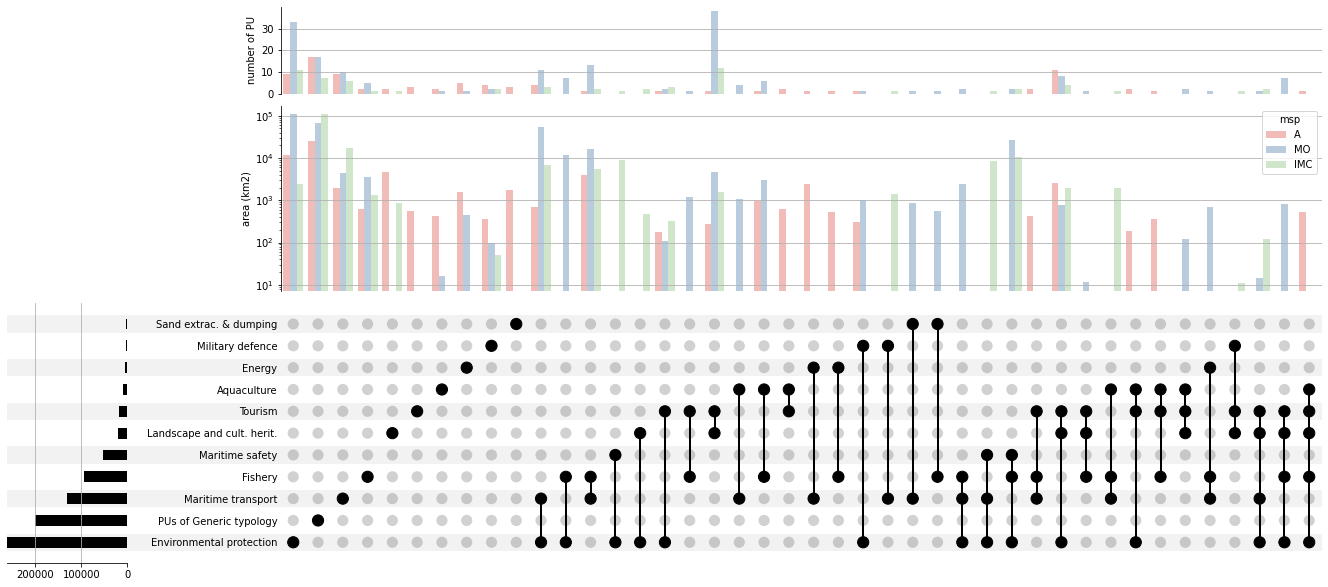

In [48]:
_df = planning_units.groupby(['main_uses_sorted_list_labels', 'msp']).agg({'geoarea': 'sum', 
                                                                           'Code': 'count'}).rename(columns={'Code': 'count'}).reset_index(['msp'])
upset_data = from_memberships(_df.index.values,
                              data=_df[['msp', 'geoarea', 'count']])
# upplot(upset_data)
upset = UpSet(upset_data,
              sum_over="geoarea",
              intersection_plot_elements=0, totals_plot_elements=5
             )  # disable the default bar chart
# upset.add_stacked_bars(by="msp", colors=cm.Pastel1,
#                        title="%", sum_over="geoarea_perc",
#                        elements=8)
upset.add_catplot(value='geoarea', kind='bar', palette="Pastel1", elements=8, hue="msp")
upset.add_catplot(value='count', kind='bar', palette="Pastel1", elements=4, hue="msp")
plots = upset.plot()
# plots['extra0']._legend.remove()
# plots['extra0'].get_legend().remove()
plots['extra0'].set(yscale="log")
plots['extra0'].set(ylabel="area (km2)")
plots['extra1'].set(ylabel="number of PU")
plots['extra1'].get_legend().remove()
plt.show()

# Cross stats

## Environmental protection

In [89]:
# remove overlaps
dfareas = None
source_stats = 'data/stats.gpkg'

n2000 = gpd.read_file(source_stats, layer="natura_2000_ita").to_crs(epsg=6875)
_types = ['A', 'B', 'C']
for t in _types:
    print('Processing type', t)
    _df = n2000[n2000.sitetype == t]
    if dfareas is None:
        dfareas = _df.copy()
    else:
        dfareas = gpd.overlay(dfareas, _df, how="union")
        dfareas['sitecode'] = dfareas[['sitecode_1', 'sitecode_2']].apply(lambda x: ';'.join(x.dropna()), axis=1)
        dfareas['sitename'] = dfareas[['sitename_1', 'sitename_2']].apply(lambda x: ';'.join(x.dropna()), axis=1)
        dfareas['sitetype'] = dfareas[['sitetype_1', 'sitetype_2']].apply(lambda x: ';'.join(x.dropna()), axis=1)
        dfareas = dfareas[['sitecode', 'sitename', 'sitetype', 'geometry']].copy()
    
# dfoverlay = gpd.overlay(planning_units, dfstats)


Processing type A
Processing type B


/opt/VirtEnv/msp_italy/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: `keep_geom_type=True` in overlay resulted in 3 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  if sys.path[0] == '':


Processing type C


/opt/VirtEnv/msp_italy/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: `keep_geom_type=True` in overlay resulted in 43 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  if sys.path[0] == '':


In [394]:
# areas stats
planning_units['env_prot'] = planning_units.main_uses.str.contains('0300')
msp_location_stats = planning_units.groupby(['msp', 'location'])[['area_km']].sum()
msp_location_stats.rename(columns={'area_km': 'pu_area'}, inplace=True)
msp_location_stats

pu_area
msp location           
A   coastal    26576.63
    offshore   35698.76
IMC coastal    41044.87
    offshore  135201.88
MO  coastal    92773.86
    offshore  216671.12

/opt/VirtEnv/msp_italy/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  """Entry point for launching an IPython kernel.


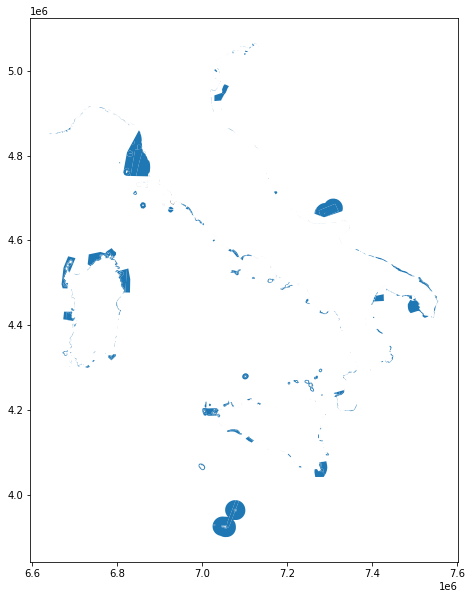

In [395]:
dfoverlay = gpd.overlay(planning_units, dfareas)
dfoverlay['env_prot'] = dfoverlay.main_uses.str.contains('0300')
dfoverlay['area_km'] = dfoverlay.geodetic_area() / 1000000
dfoverlay.plot(figsize=[10, 10])
plt.show()


In [408]:
# current situation
dfcurrent = msp_location_stats.copy()
dfcurrent['area_km'] = dfoverlay.groupby(['msp', 'location'])[['area_km']].sum()
dfcurrent['area_perc'] = dfcurrent['area_km'] / msp_location_stats.pu_area * 100
dfcurrent

pu_area       area_km  area_perc
msp location                                    
A   coastal    26576.63   3144.214679  11.830750
    offshore   35698.76      6.098668   0.017084
IMC coastal    41044.87   6550.986149  15.960548
    offshore  135201.88      0.008805   0.000007
MO  coastal    92773.86  11053.970867  11.914963
    offshore  216671.12      0.004240   0.000002

In [407]:
# planned areas
dfkm = planning_units[planning_units.env_protection].groupby(['msp', 'location', 'pu_types'])[['area_km']].sum()
dfkm = dfkm.reset_index().pivot_table(values='area_km', columns='pu_types', index=['msp', 'location'])
dfperc = dfkm.div(msp_location_stats.pu_area, axis=0) * 100
dfperc

pu_types       Limited  Prioritary  Reserved
msp location                                
A   coastal   3.362879   15.020753       NaN
    offshore       NaN   31.038333       NaN
IMC coastal   0.897652   35.264553       NaN
    offshore  0.649673   17.613283       NaN
MO  coastal   1.270315   41.621390   0.47702
    offshore       NaN   75.206082       NaN

In [575]:
# prepare current situation
_df = dfcurrent.melt(ignore_index=False, var_name='uom').reset_index()
_df['scenario'] = 'current'
_df['pu_type'] = 'Current'
df_env_prot = _df.copy()

_df = dfkm.melt(ignore_index=False, var_name='pu_type').reset_index()
_df['pu_type'] = 'Planned - ' + _df.pu_type
_df['uom'] = 'area_km'
_df['scenario'] = 'planned'
df_env_prot = pd.concat([df_env_prot, _df], ignore_index=True)

_df = dfperc.melt(ignore_index=False, var_name='pu_type').reset_index()
_df['pu_type'] = 'Planned - ' + _df.pu_type
_df['uom'] = 'area_perc'
_df['scenario'] = 'planned'
df_env_prot = pd.concat([df_env_prot, _df], ignore_index=True).fillna(0)
df_env_prot.pivot_table(index=['msp', 'location'], columns=['scenario', 'pu_type', 'uom'], values='value')

scenario           current                                 planned            \
pu_type            Current                       Planned - Limited             
uom                area_km  area_perc    pu_area           area_km area_perc   
msp location                                                                   
A   coastal    3144.214679  11.830750   26576.63            893.74  3.362879   
    offshore      6.098668   0.017084   35698.76              0.00  0.000000   
IMC coastal    6550.986149  15.960548   41044.87            368.44  0.897652   
    offshore      0.008805   0.000007  135201.88            878.37  0.649673   
MO  coastal   11053.970867  11.914963   92773.86           1178.52  1.270315   
    offshore      0.004240   0.000002  216671.12              0.00  0.000000   

scenario                                                                   
pu_type      Planned - Prioritary            Planned - Reserved            
uom                       area_km  area_perc            area_km area_perc  
msp location                                                               
A   coastal               3992.01  15.020753               0.00   0.00000  
    offshore             11080.30  31.038333               0.00   0.00000  
IMC coastal              14474.29  35.264553               0.00   0.00000  
    offshore             23813.49  17.613283               0.00   0.00000  
MO  coastal              38613.77  41.621390             442.55   0.47702  
    offshore            162949.86  75.206082               0.00   0.00000

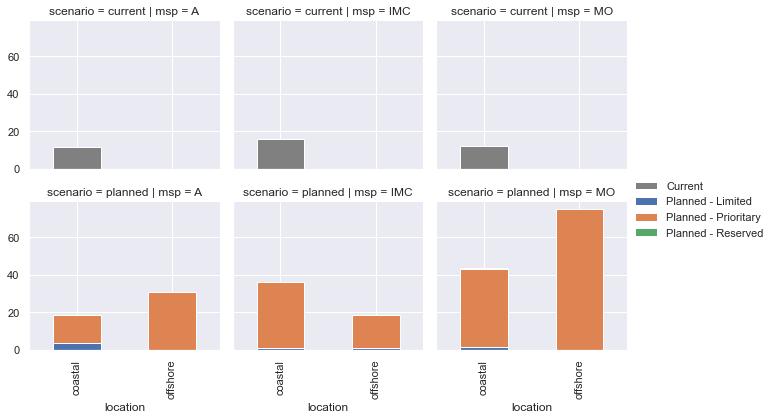

In [576]:
_data = []
def plot_barplot(data, **kws):
    color = None
    if data.scenario.iloc[0]=='current':
        color = 'grey'
    _data.append(data)
    _df = data[['location', 'value', 'pu_type']].pivot_table(values='value', columns='pu_type', index='location')
    _df.plot.bar(stacked=True, ax=plt.gca(), color=color) 
_df = df_env_prot
_df = _df[_df.uom=='area_perc']
g = sns.FacetGrid(_df, col = 'msp',  row = 'scenario')
g = (g.map_dataframe(plot_barplot).add_legend())

plt.show()

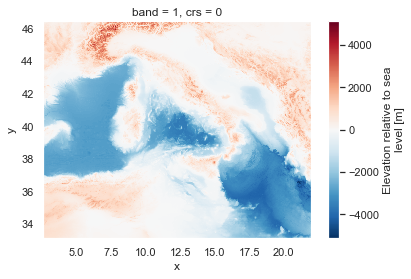

In [611]:
import rioxarray as rioxarray
gebco = rioxarray.open_rasterio('data/GEBCO2021_ita.nc')
gebco.rio.write_crs(
    4326,
    inplace=True
).rio.write_crs(
    4326,
    inplace=True,
)
gebco.sel(band=1).plot()

In [612]:
import rectifiedgrid as rg

ValueError: steps argument must be an increasing sequence of numbers between 1 and 10 inclusive

# Test geodetica area calculation
https://geographiclib.sourceforge.io/cgi-bin/Planimeter?type=polygon&rhumb=geodesic&input=59.95688345+20.13293641%0D%0A60.47397663+26.94617837%0D%0A62.56499443+29.74782155%0D%0A68.70650340+27.45254202%0D%0A68.24937206+23.75771765%0D%0A65.27444593+25.42698984%0D%0A63.10353609+21.51545237%0D%0A61.12318104+21.40562760%0D%0A60.40477513+19.41123592%0D%0A59.95688345+20.13293641&option=Submit


Discussione di gen-feb 2021 che spiega il cambio di librerie in qgis per il calcolo dell'area. Uso delle GeographicLib (le stesse di Proj) invece di usare l'approccio di GRASS (anche GRASS nello stesso periodo ha fatto la stessa modifica per allinearsi):
* https://github.com/qgis/QGIS/issues/40888

Patch sulla master di QGIS del 21 feb 2021 che introduce l'uso delle GeographicLib:
* https://github.com/qgis/QGIS/pull/41726/files/b17dbff7e510c58abebfff73dc164a89dcf03471

Pull request relativa. Le modifiche sono state introdotte nella 3.20 di QGIS
* https://github.com/qgis/QGIS/pull/41726

QGIS 3.16.3 non ha ancora la patch per le GeographicLib
* https://github.com/qgis/QGIS/blob/94ac9f21b8b7e36d3aa9715922ad15a7bf62fdae/python/core/auto_generated/qgsdistancearea.sip.in

Testare la conversione in pyproj
* https://geographiclib.sourceforge.io/cgi-bin/Planimeter?type=polygon&rhumb=geodesic&input=59.95688345+20.13293641%0D%0A60.47397663+26.94617837%0D%0A62.56499443+29.74782155%0D%0A68.70650340+27.45254202%0D%0A68.24937206+23.75771765%0D%0A65.27444593+25.42698984%0D%0A63.10353609+21.51545237%0D%0A61.12318104+21.40562760%0D%0A60.40477513+19.41123592%0D%0A59.95688345+20.13293641&option=Submit
* area (m^2) = 251199344354.4
* Perimeter (m) = 2578086.202363


In [557]:
from shapely.geometry import Polygon

area_test = 251199344354.4

coords = (
    (20.13293641, 59.95688345),
    (26.94617837, 60.47397663),
    (29.74782155, 62.56499443),
    (27.45254202, 68.70650340),
    (23.75771765, 68.24937206),
    (25.42698984, 65.27444593),
    (21.51545237, 63.10353609),
    (21.40562760, 61.12318104),
    (19.41123592, 60.40477513),
    (20.13293641, 59.95688345),
    )
polygon = Polygon(coords)
geod_wgs84 = Geod(ellps="WGS84")
poly_area, poly_perimeter = geod_wgs84.geometry_area_perimeter(polygon)
print(poly_area, poly_perimeter)
poly_area - area_test

251199344354.43042 2578086.2023629267


0.030426025390625

In [724]:
pu_n_area = planning_units.groupby(['msp', 'location','pu_type', 'n_main'])[['kmq']].sum()
pu_n_area

kmq
msp location pu_type n_main               
A   costiera 200     False     6619.853228
                     True      1474.445853
             300     True        35.348302
             400     False      122.696779
    offshore 200     False     5479.982500
                     True     11080.309652
             300     True         0.713219
IMC costiera 200     False    10146.705660
                     True      7533.682094
             300     True       200.836904
    offshore 200     False    15655.535966
                     True     23964.842321
             300     True      1094.873103
MO  costiera 200     False    29050.031943
                     True     33089.751984
             300     True      1177.698374
             400     False       99.772866
                     True       442.552290
    offshore 200     False     3470.140232
                     True    167698.039158

In [702]:
# pu_n_area.to_csv('./data/somme_up.txt')
adriatic_n = planning_units[(planning_units['msp']=='A')& planning_units['n_main']]
tot = adriatic_n['kmq'].sum()
tot
#pu_n_area.sort_values(by=['Code'])

12590.817025109402

In [560]:
shp =  'data/up_natura.shp'
up = gpd.read_file(shp)

up['subarea'] = up.Code.str.replace('_\d+', '')
ups = up.groupby(['area', 'location'])[['nat2k_mpa_']].sum()
ups


nat2k_mpa_
area location              
A    costiera   3109.504524
     offshore      6.759688
IMC  costiera   6637.898902
     offshore      0.008805
MO   costiera  11099.068585
     offshore      0.004240